In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/AMAZON ML CHALLENGE"

68e8d1d70b66d_student_resource	68e8d1d70b66d_student_resource.zip


In [15]:
# df_train.describe()

,sample_id,price
count,75000.000000,75000.000000
mean,149841.917707,23.647654
std,86585.346513,33.376932
min,0.000000,0.130000
25%,73845.750000,6.795000
50%,150129.000000,14.000000
75%,225040.250000,28.625000
max,299438.000000,2796.000000


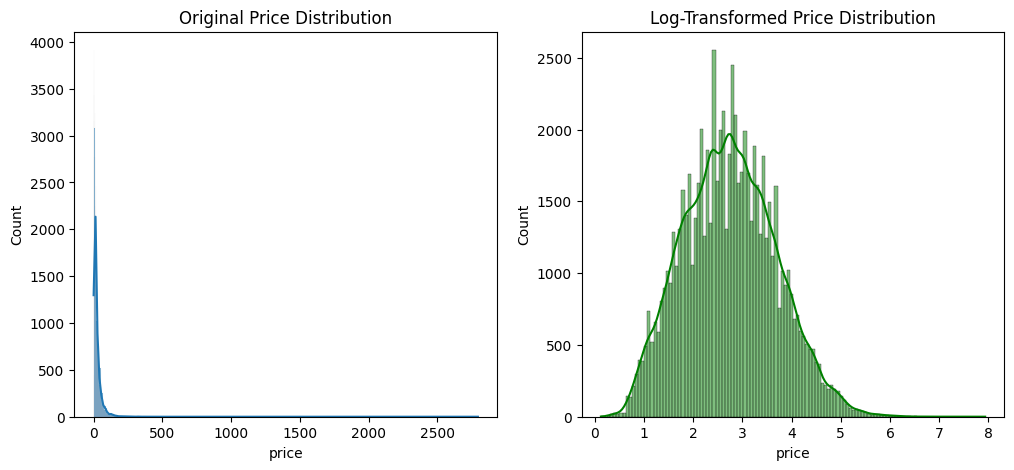

In [16]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Set up the plot
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original price distribution
# sns.histplot(df_train['price'], ax=axes[0], kde=True)
# axes[0].set_title('Original Price Distribution')

# Plot log-transformed price distribution
# sns.histplot(np.log1p(df_train['price']), ax=axes[1], kde=True, color='green')
# axes[1].set_title('Log-Transformed Price Distribution')

# plt.show()

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [5]:
# --- 1. Paths ---
BASE_PATH = "/content/drive/MyDrive/AMAZON ML CHALLENGE/68e8d1d70b66d_student_resource/student_resource"
DATASET_FOLDER = os.path.join(BASE_PATH, 'dataset/')
train_path = os.path.join(DATASET_FOLDER, 'train.csv')

In [6]:
# --- 2. Load the training data ---
df_full = pd.read_csv(train_path)
print(f"Full dataset shape: {df_full.shape}")

Full dataset shape: (75000, 4)


In [7]:
# --- 3. Prepare for Stratified Sampling (Corrected) ---

# First, create the log-transformed price
df_full['price_log'] = np.log1p(df_full['price'])

# Second, create discrete bins. We'll use 10 bins instead of 17.
# This is a safer number that will prevent single-member bins.
df_full['price_bin'] = pd.cut(df_full['price_log'], bins=10, labels=False)

In [8]:
# --- 4. Create the Stratified Sample (This will work now) ---
sample_size_fraction = 20000 / len(df_full)

df_sample, _ = train_test_split(
    df_full,
    train_size=sample_size_fraction,
    stratify=df_full['price_bin'],
    random_state=42
)

# Clean up the bin column from the sample
df_sample = df_sample.drop('price_bin', axis=1)

In [9]:
df_sample.shape

(20000, 5)

In [10]:
df_full.describe()

,sample_id,price,price_log,price_bin
count,75000.000000,75000.000000,75000.000000,75000.000000
mean,149841.917707,23.647654,2.739217,2.854893
std,86585.346513,33.376932,0.942032,1.239835
min,0.000000,0.130000,0.122218,0.000000
25%,73845.750000,6.795000,2.053483,2.000000
50%,150129.000000,14.000000,2.708050,3.000000
75%,225040.250000,28.625000,3.388619,4.000000
max,299438.000000,2796.000000,7.936303,9.000000


In [11]:
df_sample.describe()

,sample_id,price,price_log
count,20000.000000,20000.000000,20000.000000
mean,150154.039100,23.690814,2.738668
std,86891.851761,36.629508,0.942193
min,16.000000,0.300000,0.262364
25%,73493.000000,6.798750,2.053963
50%,151309.500000,14.125000,2.716349
75%,225644.750000,28.450000,3.382694
max,299438.000000,2796.000000,7.936303


In [39]:
# --- 5. Save the Sample to a New File ---
# sample_save_path = os.path.join(DATASET_FOLDER, 'train_sample.csv')
# df_sample.to_csv(sample_save_path, index=False)

# print(f"\n✅ Sample saved successfully to: {sample_save_path}")


✅ Sample saved successfully to: /content/drive/MyDrive/AMAZON ML CHALLENGE/68e8d1d70b66d_student_resource/student_resource/dataset/train_sample.csv


In [12]:
# ----------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx-------------------------------------
# NOW TO BUILD ONLY UNPROCESSED TEXT MODEL

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

In [19]:
# --- 1. Define your features (X) and target (y) ---

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

X = tfidf_vectorizer.fit_transform(df_sample['catalog_content'])

y = df_sample['price_log']

In [20]:
# --- 2. Define Your Model and CV Strategy ---
model = Ridge(random_state=42)

# To stratify for regression, we need to bin the target variable again
# This ensures each fold has a representative mix of prices
price_bins = pd.cut(df_sample['price_log'], bins=10, labels=False)
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
from sklearn.metrics import make_scorer

# --- 1. Define the SMAPE Scorer ---
def smape(y_true_log, y_pred_log):
    """Calculates SMAPE on log-transformed values."""
    # Convert back to original price scale
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)

    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio)

# Create a scorer object. Lower is better, so greater_is_better=False
smape_scorer = make_scorer(smape, greater_is_better=False)

In [25]:
# --- 3. Run Cross-Validation ---
# NOTE: For regression, sklearn's scoring metrics are negative (e.g., 'neg_root_mean_squared_error').
# A higher value (closer to 0) is better. We multiply by -1 to make it positive and easier to read.
print("Running 5-fold cross-validation...")
scores = cross_val_score(
    estimator=model,
    X=X,
    y=y,
    cv=cv_strategy,
    scoring=smape_scorer, # Using RMSE on the log-price for now we need SMAPE waise to
    n_jobs=-1
)

Running 5-fold cross-validation...


In [27]:
smape_scores = -scores

print(f"SMAPE Scores for each fold: {smape_scores}")
print(f"CV SMAPE (Mean): {smape_scores.mean():.4f}")
print(f"CV SMAPE (Std Dev): {smape_scores.std():.4f}")

SMAPE Scores for each fold: [0.59178764 0.59553434 0.59832489 0.58971694 0.59695298]
CV SMAPE (Mean): 0.5945
CV SMAPE (Std Dev): 0.0032
